## Importing libraries 

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import eda_helper_functions
from sklearn.ensemble import IsolationForest



## Read the training data 

In [63]:
file_path= r"E:\flight price prediction using sagemaker\dataset\train.csv"
train = pd.read_csv(file_path)
train.head()

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,date_of_Journey,price
0,Jet Airways,Delhi,Cochin,14:35:00,12:35:00,1320,2.0,In-flight meal not included,2019-06-15,10919
1,Spicejet,Banglore,New Delhi,10:20:00,18:15:00,475,1.0,No Info,2019-03-09,7294
2,Indigo,Banglore,New Delhi,20:00:00,22:55:00,175,0.0,No Info,2019-03-03,6860
3,Multiple Carriers,Delhi,Cochin,04:55:00,19:15:00,860,1.0,No Info,2019-05-21,7575
4,Vistara,Banglore,Delhi,19:30:00,22:15:00,165,0.0,No Info,2019-04-06,5613


In [64]:
train.dtypes

airline             object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
date_of_Journey     object
price                int64
dtype: object

In [65]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_Journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
date_of_Journey    datetime64[ns]
price                       int64
dtype: object

In [66]:
train

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,date_of_Journey,price
0,Jet Airways,Delhi,Cochin,2024-05-30 14:35:00,2024-05-30 12:35:00,1320,2.0,In-flight meal not included,2019-06-15,10919
1,Spicejet,Banglore,New Delhi,2024-05-30 10:20:00,2024-05-30 18:15:00,475,1.0,No Info,2019-03-09,7294
2,Indigo,Banglore,New Delhi,2024-05-30 20:00:00,2024-05-30 22:55:00,175,0.0,No Info,2019-03-03,6860
3,Multiple Carriers,Delhi,Cochin,2024-05-30 04:55:00,2024-05-30 19:15:00,860,1.0,No Info,2019-05-21,7575
4,Vistara,Banglore,Delhi,2024-05-30 19:30:00,2024-05-30 22:15:00,165,0.0,No Info,2019-04-06,5613
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,Delhi,Cochin,2024-05-30 14:00:00,2024-05-30 01:30:00,690,1.0,No Info,2019-05-15,13727
636,Indigo,Mumbai,Hyderabad,2024-05-30 12:00:00,2024-05-30 13:30:00,90,0.0,No Info,2019-05-09,4392
637,Indigo,Banglore,Delhi,2024-05-30 23:30:00,2024-05-30 02:20:00,170,0.0,No Info,2019-04-27,3943
638,Jet Airways,Kolkata,Banglore,2024-05-30 21:10:00,2024-05-30 08:15:00,665,1.0,No Info,2019-05-01,14781


## 3. High-level Summary of Data

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   source           640 non-null    object        
 2   destination      640 non-null    object        
 3   dep_time         640 non-null    datetime64[ns]
 4   arrival_time     640 non-null    datetime64[ns]
 5   duration         640 non-null    int64         
 6   total_stops      640 non-null    float64       
 7   additional_info  640 non-null    object        
 8   date_of_Journey  640 non-null    datetime64[ns]
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [68]:
train.describe(include='number')

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,620.515625,0.825000,9006.150000
std,477.581249,0.645679,4141.301489
min,75.000000,0.000000,1965.000000
25%,175.000000,0.000000,5678.000000
50%,515.000000,1.000000,8085.000000
75%,865.000000,1.000000,12275.750000
max,2300.000000,3.000000,26890.000000


In [69]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,5
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,227,278,278,357.0,499


## 4. High-level analysis of Missing Values

In [70]:

eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## 5. High-level analysis of Outliers

In [71]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [72]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	#.duration
	#.describe()
)

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,date_of_Journey,price,outlier
0,Jet Airways,Delhi,Cochin,2024-05-30 14:35:00,2024-05-30 12:35:00,1320,2.0,In-flight meal not included,2019-06-15,10919,-1
2,Indigo,Banglore,New Delhi,2024-05-30 20:00:00,2024-05-30 22:55:00,175,0.0,No Info,2019-03-03,6860,-1
5,Vistara,Delhi,Cochin,2024-05-30 06:00:00,2024-05-30 09:10:00,190,0.0,No Info,2019-06-06,6216,-1
8,Jet Airways,Delhi,Cochin,2024-05-30 20:55:00,2024-05-30 19:00:00,1325,1.0,In-flight meal not included,2019-05-09,12373,-1
9,Air India,Banglore,New Delhi,2024-05-30 08:50:00,2024-05-30 16:20:00,1890,2.0,No Info,2019-03-12,12778,-1
...,...,...,...,...,...,...,...,...,...,...,...
622,Air India,Delhi,Cochin,2024-05-30 22:00:00,2024-05-30 19:15:00,1275,2.0,No Info,2019-06-12,10231,-1
623,Air India,Delhi,Cochin,2024-05-30 14:10:00,2024-05-30 17:10:00,180,0.0,No Info,2019-06-01,6934,-1
626,Spicejet,Mumbai,Hyderabad,2024-05-30 05:45:00,2024-05-30 07:15:00,90,0.0,No Info,2019-06-27,2017,-1
627,Vistara,Delhi,Cochin,2024-05-30 06:00:00,2024-05-30 09:10:00,190,0.0,No Info,2019-04-24,6216,-1


## 6. Pair Plots

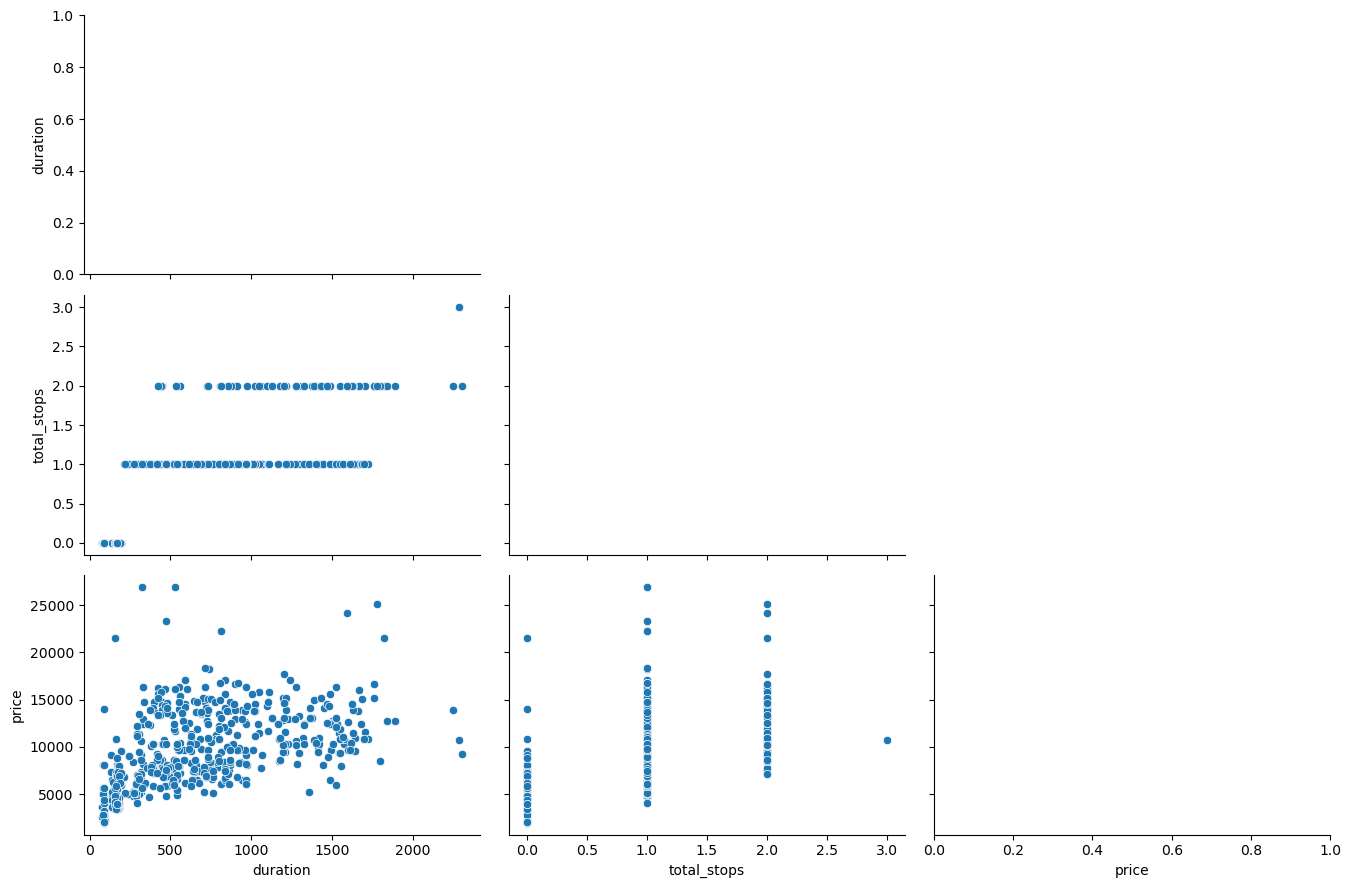

In [73]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

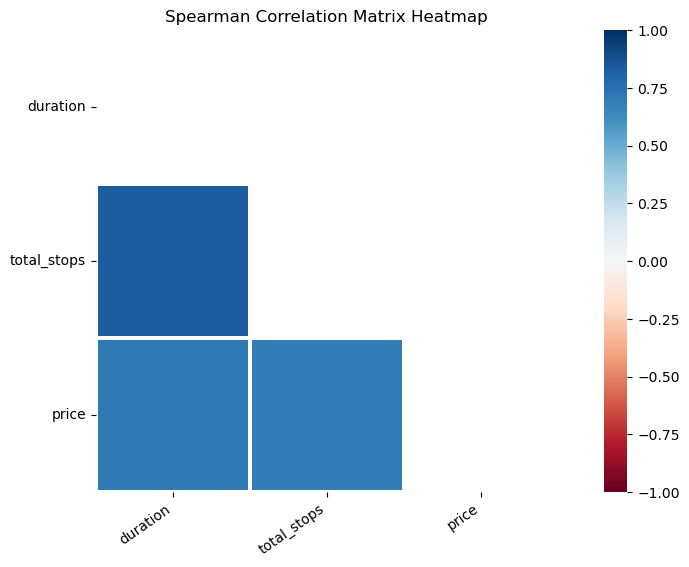

In [74]:
eda_helper_functions.correlation_heatmap(train)

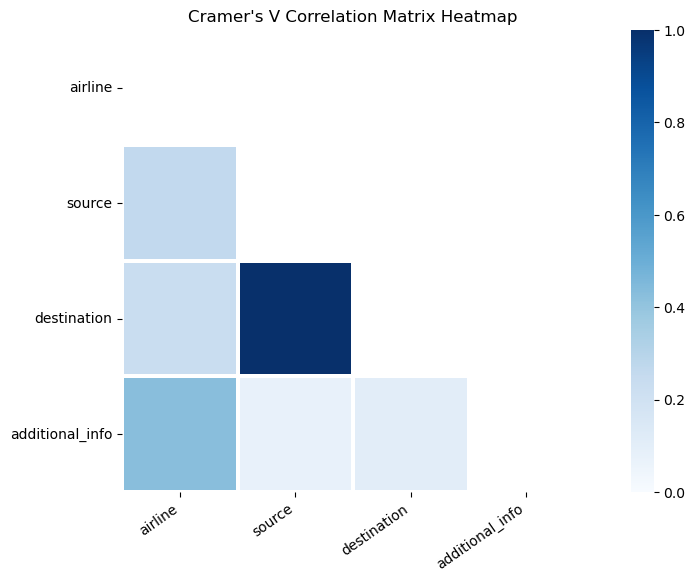

In [75]:
eda_helper_functions.cramersV_heatmap(train)

In [76]:
train.corr(method="spearman",numeric_only=True)

,duration,total_stops,price
duration,1.000000,0.828566,0.717003
total_stops,0.828566,1.000000,0.697264
price,0.717003,0.697264,1.000000


In [112]:
train.isna().sum()

airline            0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
date_of_Journey    0
price              0
dtype: int64

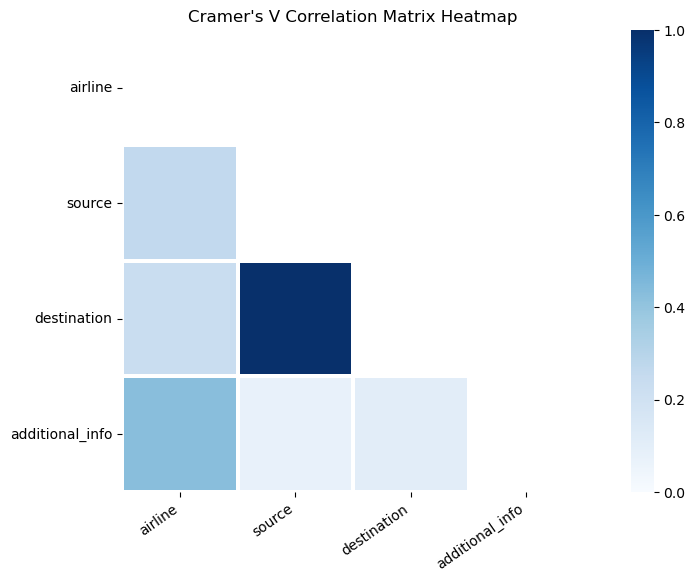

In [110]:

eda_helper_functions.cramersV_heatmap(train)


## Detailed analysis

In [78]:
train.columns

Index(['airline', 'source', 'destination', 'dep_time', 'arrival_time',
       'duration', 'total_stops', 'additional_info', 'date_of_Journey',
       'price'],
      dtype='object')

### 8.1 airline

In [79]:
train.airline

0            Jet Airways
1               Spicejet
2                 Indigo
3      Multiple Carriers
4                Vistara
             ...        
635    Multiple Carriers
636               Indigo
637               Indigo
638          Jet Airways
639               Indigo
Name: airline, Length: 640, dtype: object

In [80]:
eda_helper_functions.cat_summary(train, "airline")

0            Jet Airways
1               Spicejet
2                 Indigo
3      Multiple Carriers
4                Vistara
             ...        
635    Multiple Carriers
636               Indigo
637               Indigo
638          Jet Airways
639               Indigo
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,227


,count,percentage
category,,
Jet Airways,227,0.354687
Indigo,125,0.195312
Air India,103,0.160938
Multiple Carriers,76,0.118750
Spicejet,45,0.070312
Vistara,34,0.053125
Air Asia,21,0.032813
Goair,9,0.014063


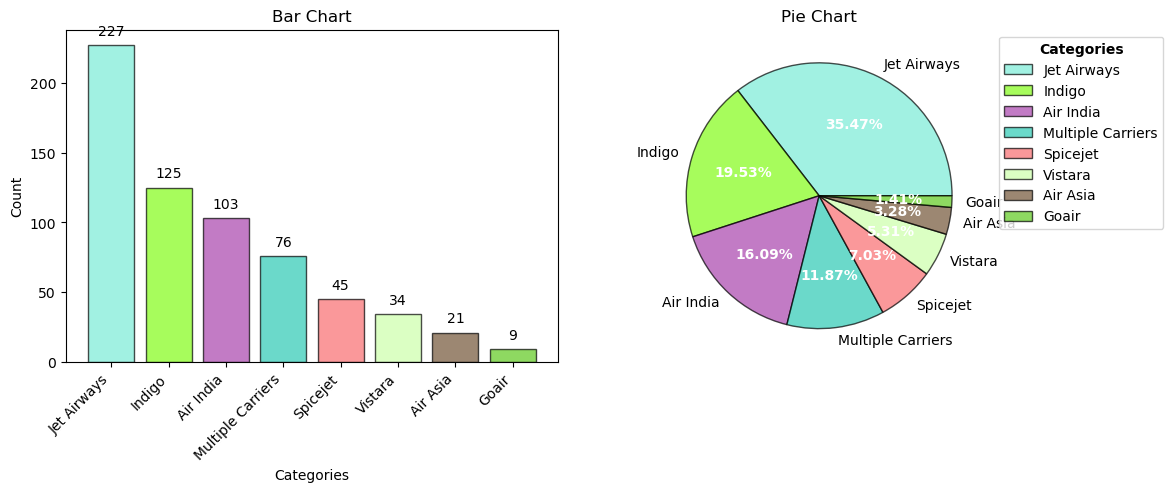

In [106]:
eda_helper_functions.cat_univar_plots(train, "airline",show_wordcloud=False)

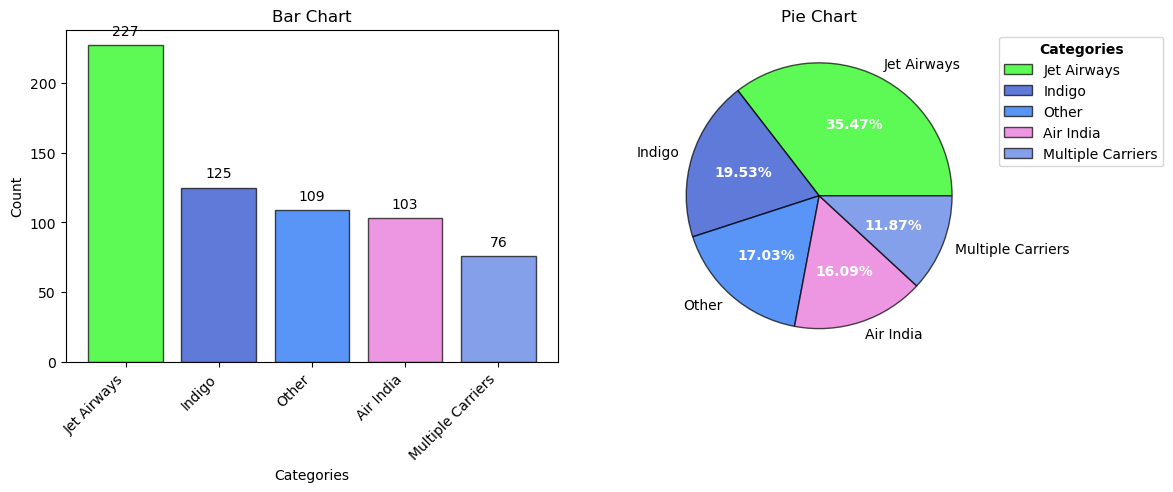

In [113]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=4)

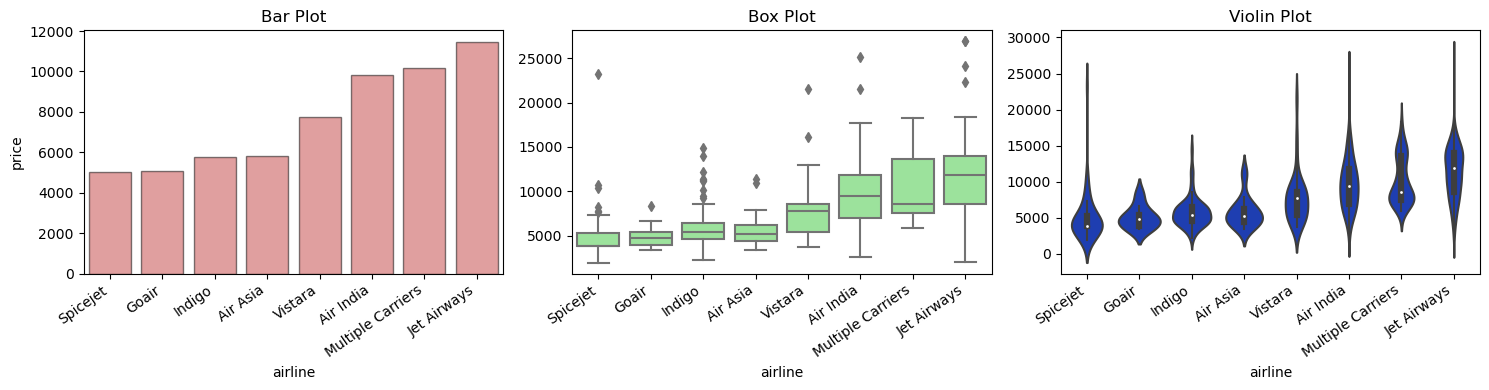

In [83]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

In [84]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 51.03361567856677
- p-value              : 1.398813579109156e-57
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 283.0028558105008
- p-value              : 2.568755109318823e-57
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


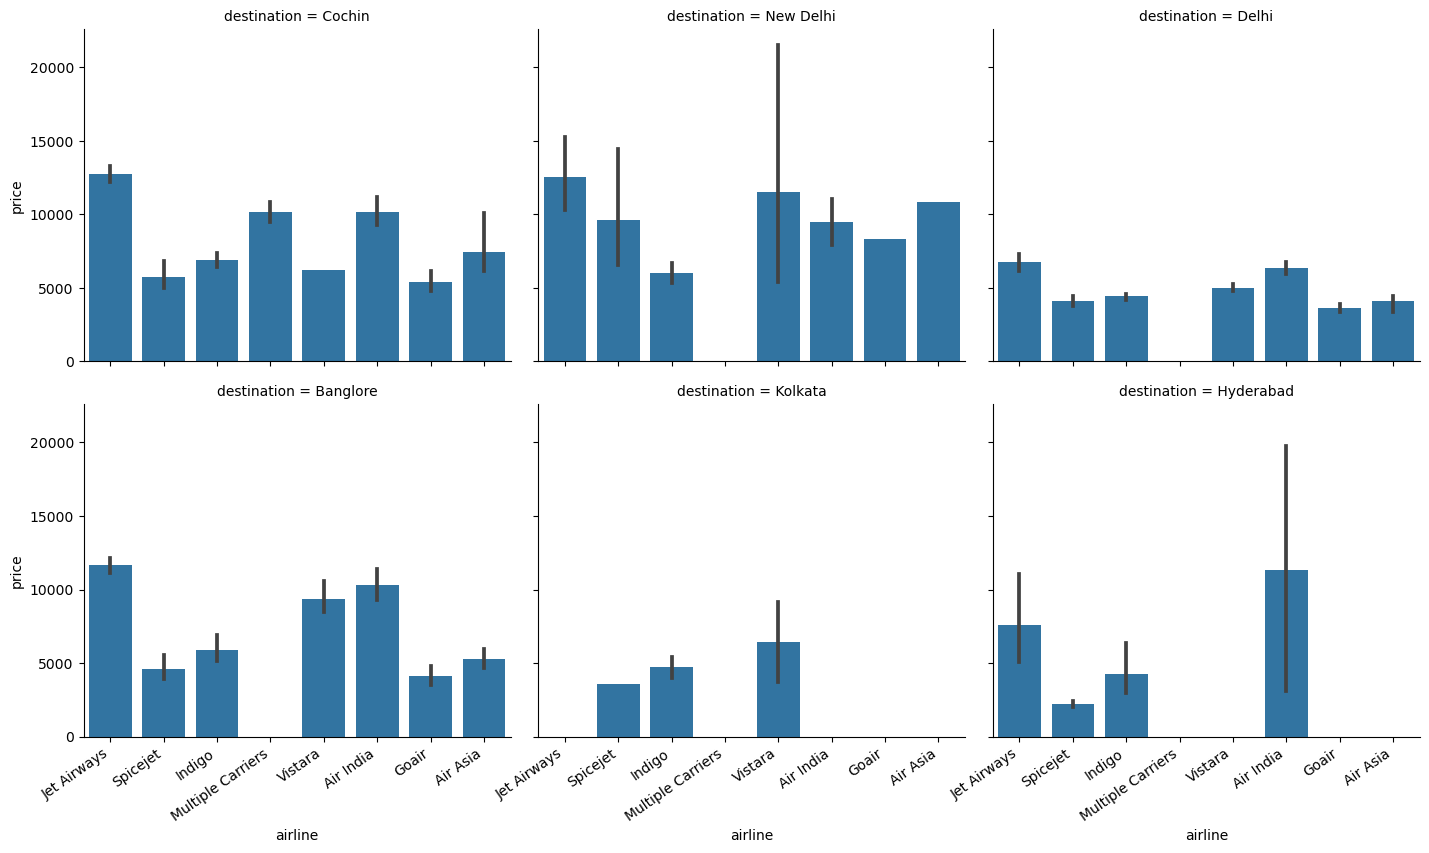

In [85]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
	eda_helper_functions.rotate_xlabels(ax)

In [86]:
train.date_of_Journey	

0     2019-06-15
1     2019-03-09
2     2019-03-03
3     2019-05-21
4     2019-04-06
         ...    
635   2019-05-15
636   2019-05-09
637   2019-04-27
638   2019-05-01
639   2019-06-01
Name: date_of_Journey, Length: 640, dtype: datetime64[ns]

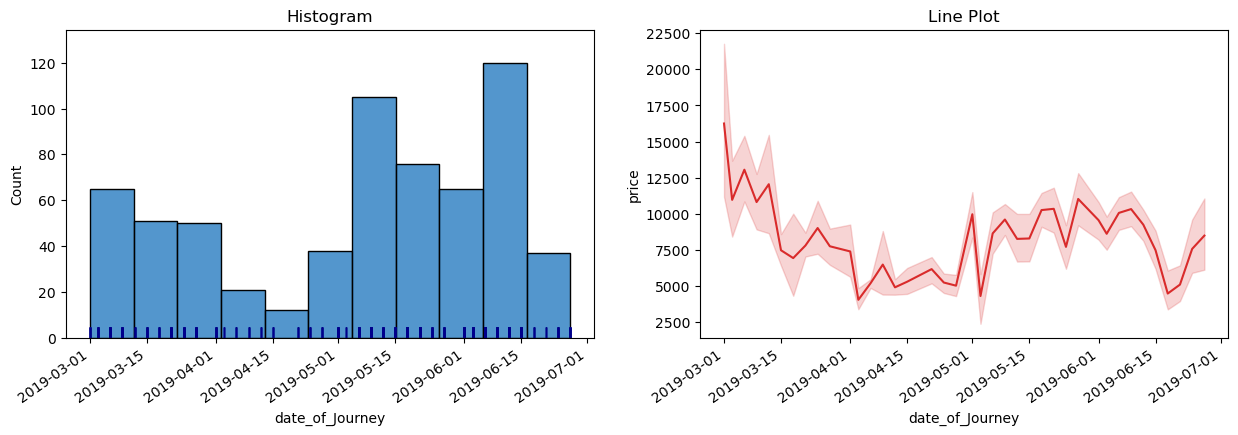

In [87]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_Journey",
	target="price"
)

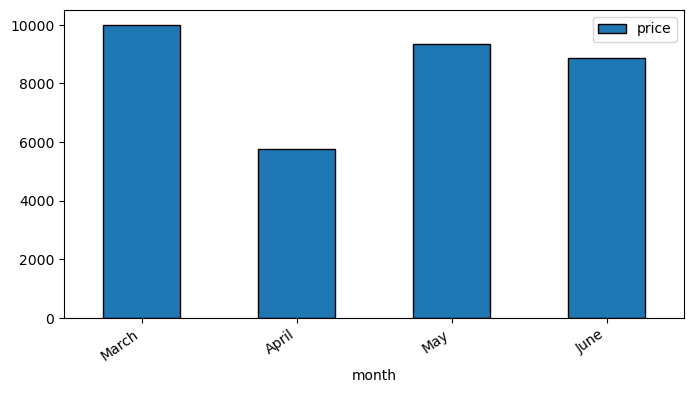

In [88]:
(
	train
	.groupby(pd.Grouper(key="date_of_Journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

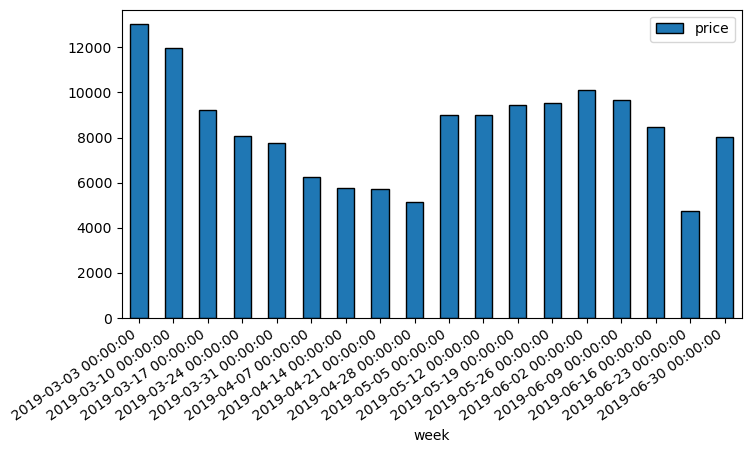

In [89]:
(
	train
	.groupby(pd.Grouper(key="date_of_Journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

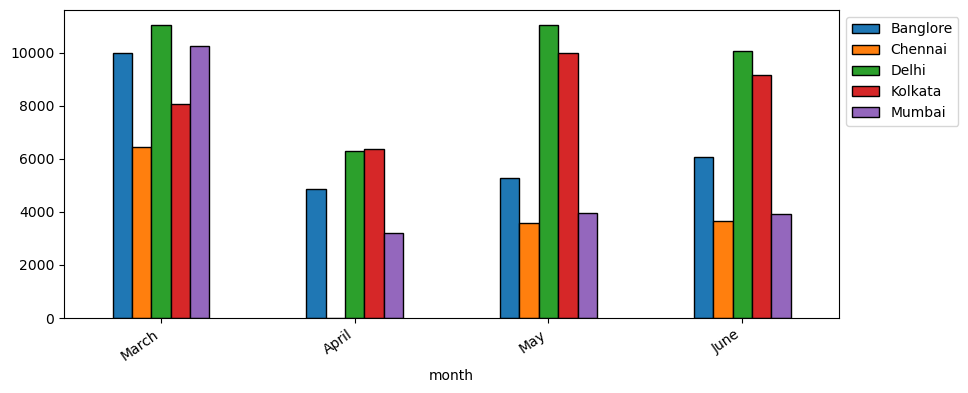

In [114]:
(
	train
	.groupby([pd.Grouper(key="date_of_Journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(10, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 8.3 dep_time

In [91]:
train.dep_time

0     2024-05-30 14:35:00
1     2024-05-30 10:20:00
2     2024-05-30 20:00:00
3     2024-05-30 04:55:00
4     2024-05-30 19:30:00
              ...        
635   2024-05-30 14:00:00
636   2024-05-30 12:00:00
637   2024-05-30 23:30:00
638   2024-05-30 21:10:00
639   2024-05-30 04:00:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

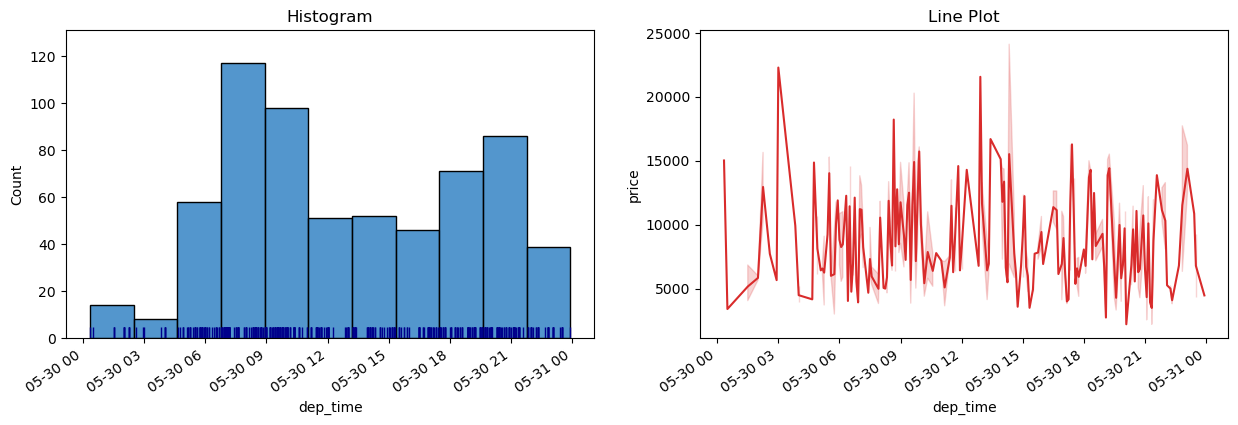

In [92]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

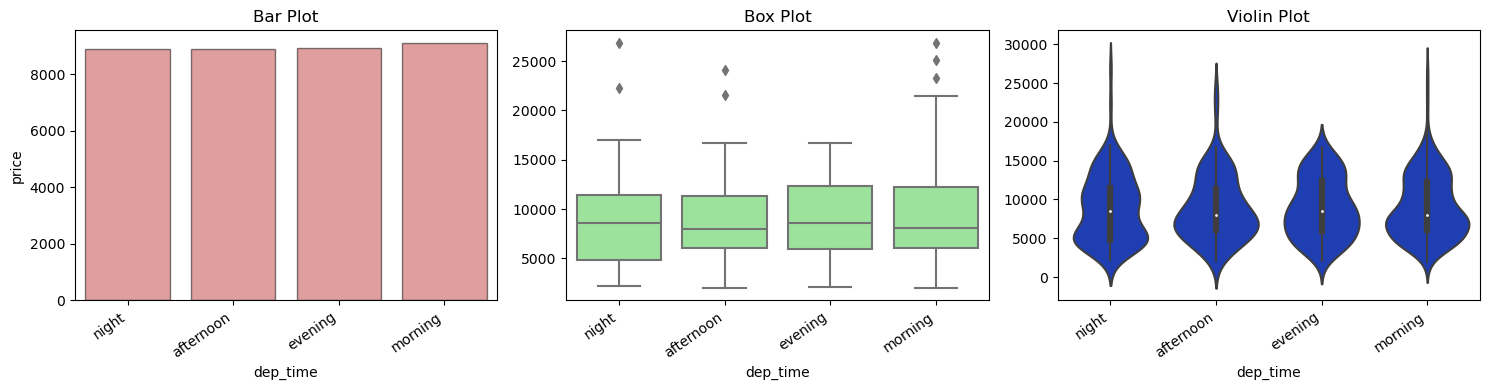

In [93]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### 8.4 duration

In [94]:
train.duration

0      1320
1       475
2       175
3       860
4       165
       ... 
635     690
636      90
637     170
638     665
639     170
Name: duration, Length: 640, dtype: int64

In [95]:
eda_helper_functions.num_summary(train, "duration")

0      1320
1       475
2       175
3       860
4       165
       ... 
635     690
636      90
637     170
638     665
639     170
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.00
5,94.75
10,150.00
25,175.00
50,515.00
75,865.00
90,1415.50
95,1550.25
99,1787.20


,value
mean,620.515625
trimmed mean (5%),588.515625
trimmed mean (10%),559.951172
median,515.000000


,value
var,228083.849521
std,477.581249
IQR,690.000000
mad,340.000000
coef_variance,0.769652


,value
skewness,0.901746
kurtosis,-0.012856


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 8.53631865227772e-21
Test Statistic       : 0.8917255827598664
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 21.852449174552476
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [96]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    175.0
0.50    515.0
0.75    865.0
Name: duration, dtype: float64

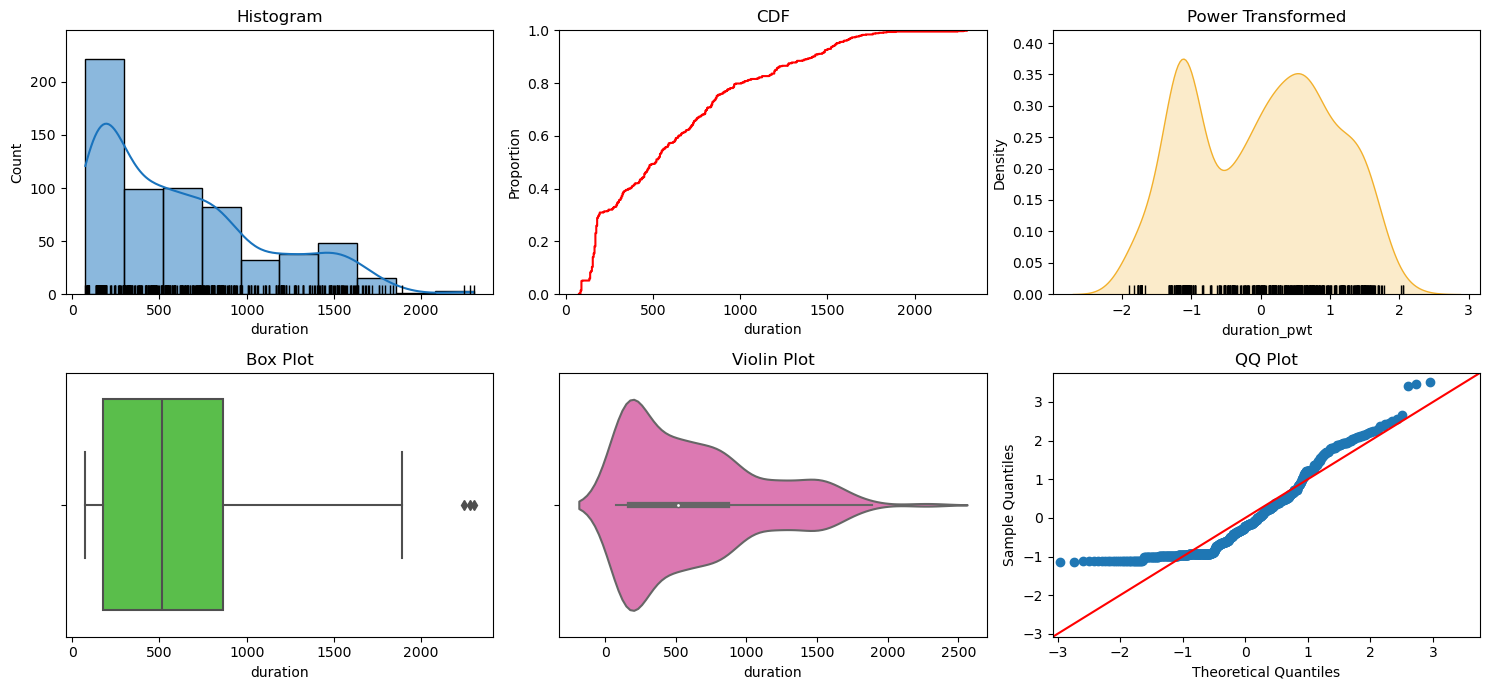

In [97]:
eda_helper_functions.num_univar_plots(train, "duration")

In [98]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.578740739595357
- p-value              : 1.6903114447870033e-58
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.7170032187754668
- p-value              : 4.5027773700876036e-102
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


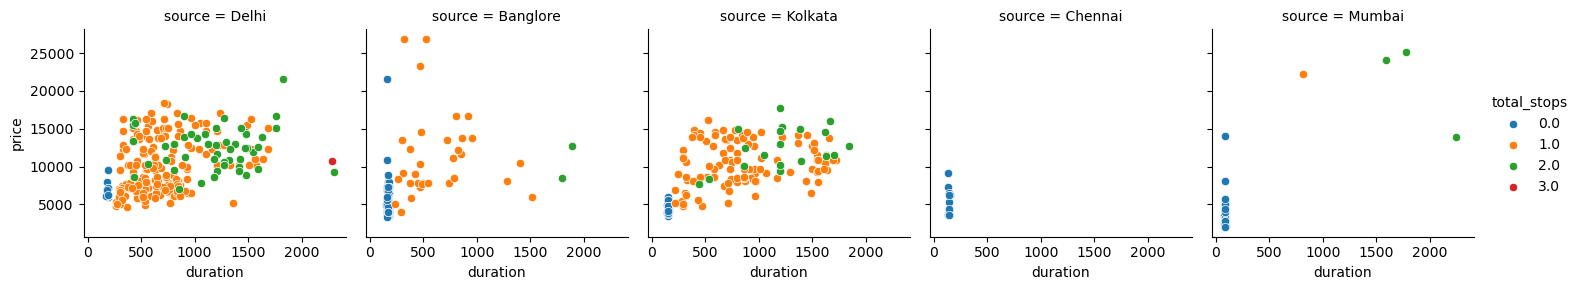

In [99]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

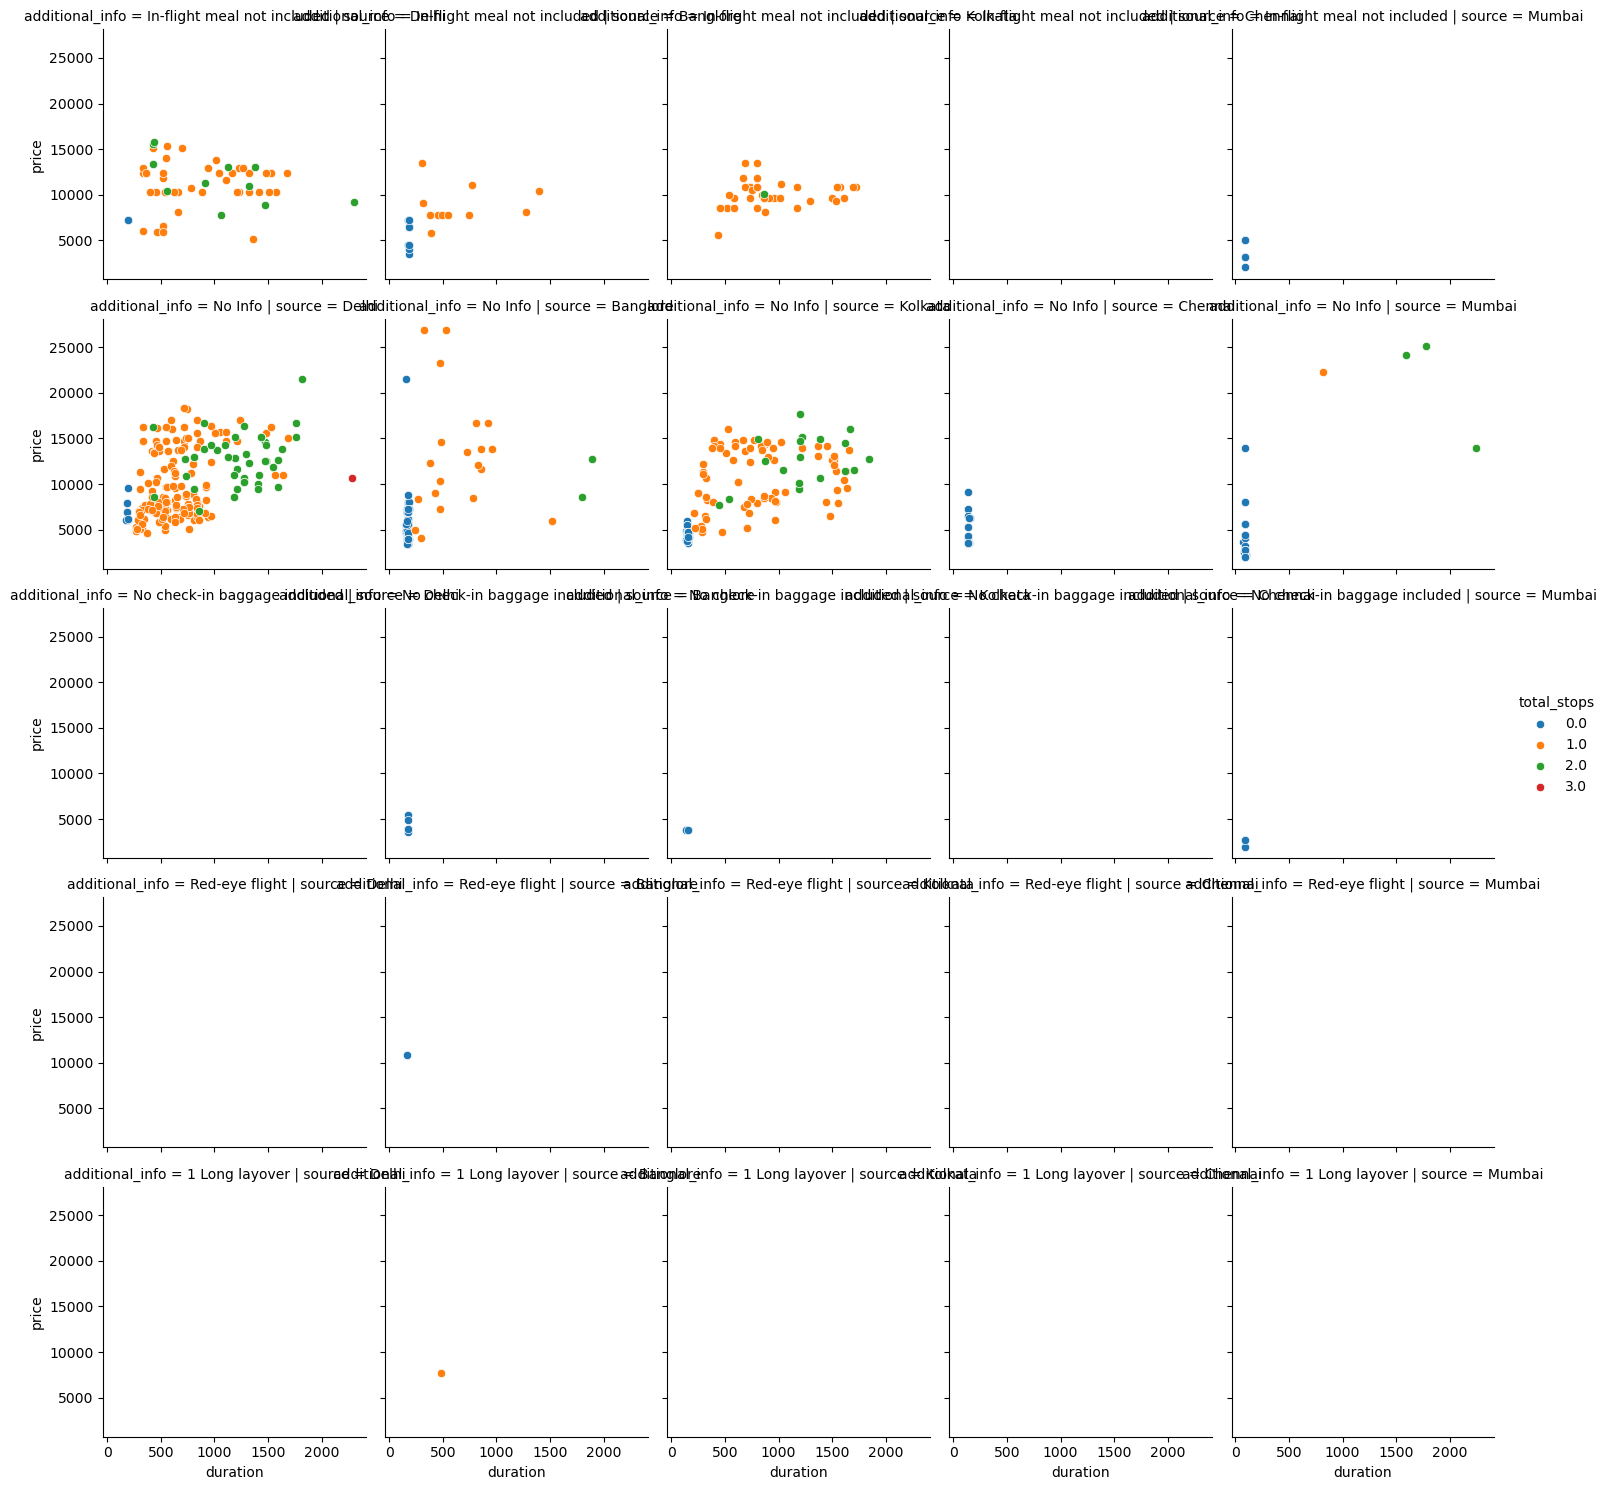

In [100]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [101]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -860.0
Upper Limit : 1900.0


,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,date_of_Journey,price
577,Air India,Mumbai,Hyderabad,2024-05-30 06:00:00,2024-05-30 19:25:00,2245,2.0,No Info,2019-03-06,13904
454,Air India,Delhi,Cochin,2024-05-30 05:15:00,2024-05-30 19:15:00,2280,3.0,No Info,2019-05-18,10703
566,Jet Airways,Delhi,Cochin,2024-05-30 05:25:00,2024-05-30 19:45:00,2300,2.0,In-flight meal not included,2019-03-27,9254


### 8.5 additional_info

In [102]:
eda_helper_functions.cat_summary(train, "additional_info")

0      In-flight meal not included
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,5
top,No Info
freq,499


,count,percentage
category,,
No Info,499,0.779687
In-flight meal not included,123,0.192188
No check-in baggage included,16,0.025000
Red-eye flight,1,0.001563
1 Long layover,1,0.001563


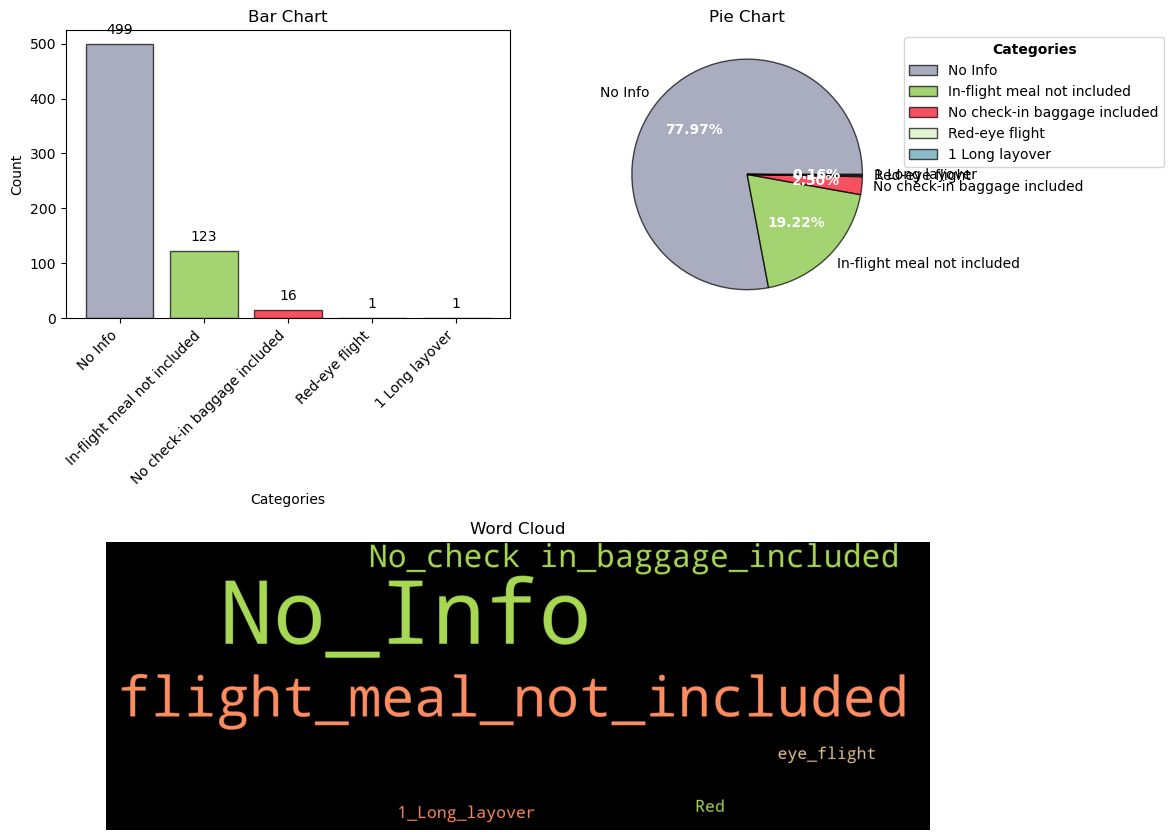

In [103]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

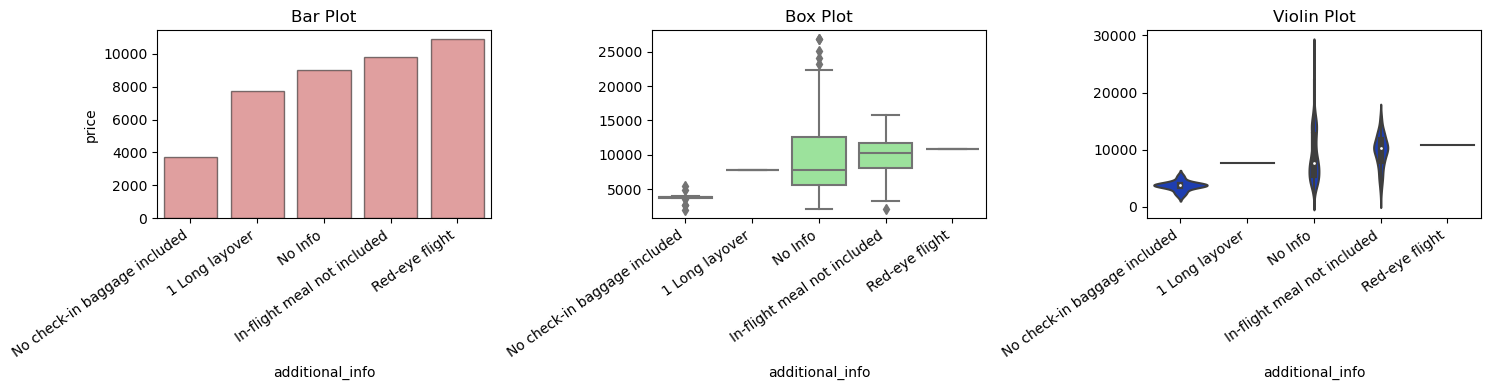

In [104]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

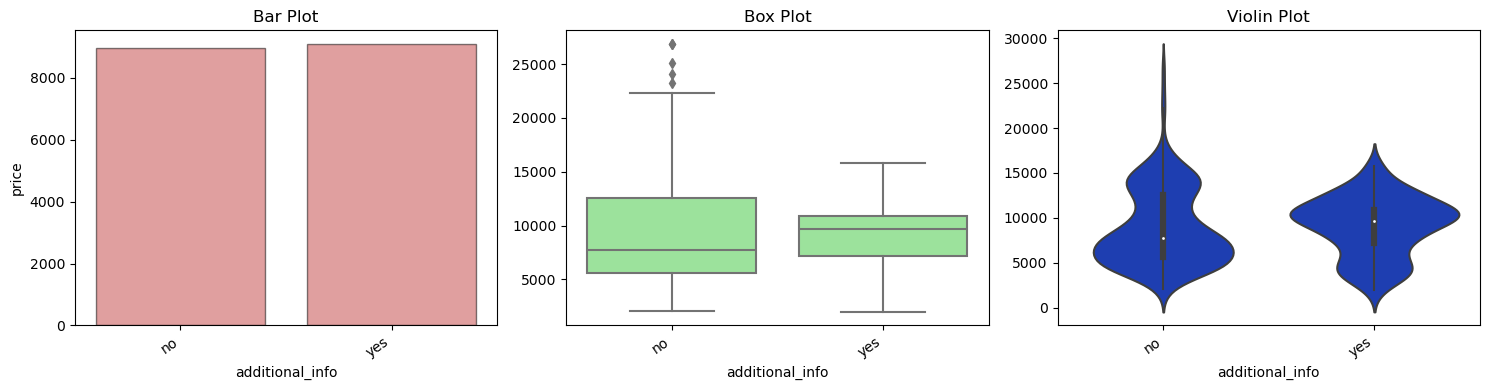

In [105]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)